In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

In [2]:
df_id = pd.read_csv("active_studs.csv")
df_groups = pd.read_csv("groups.csv", sep=";")
df_checks = pd.read_csv("checks.csv", sep=";")

In [3]:
df_groups.rename(columns={"grp": "group"}, inplace=True)
df_checks.rename(columns={"student_id": "id"}, inplace=True)
df_id.rename(columns={"student_id": "id"}, inplace=True)

In [4]:
data = pd.merge(df_groups, df_checks, left_on="id", right_on="id")
data = pd.merge(data, df_id, left_on="id", right_on="id")

data.head(5)

,id,group,rev
0,5378875,B,590.0
1,1477204,B,3040.0
2,3206185,B,290.0
3,4002619,A,2890.0
4,4202732,B,290.0


In [5]:
data.nunique()

id       392
group      2
rev       38
dtype: int64

In [6]:
data["group"].value_counts()

B    314
A     78
Name: group, dtype: int64

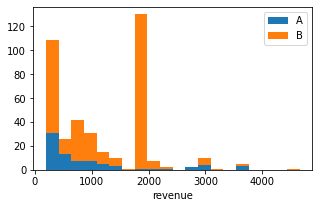

In [7]:
plt.figure(figsize=(5, 3))
plt.hist([(data[data["group"] == "A"]["rev"]), (data[data["group"] == "B"]["rev"])], 
         bins=20, 
         stacked=True, 
         label=["A", "B"])
plt.legend()
plt.xlabel("revenue")
plt.show()

In [8]:
A = data.query("group == 'A'").rev
A.head(5)

3     2890.0
10     199.0
18     290.0
20     990.0
22     990.0
Name: rev, dtype: float64

In [9]:
A = data[data["group"] == "A"]["rev"].values
B = data[data["group"] == "B"]["rev"].values

In [10]:
np.median(A), np.median(B)

(585.0, 1140.0)

In [11]:
np.mean(A), np.mean(B)

(933.5897435897435, 1257.8789920382164)

In [12]:
def plot_the_couple(pvals, N, power, alpha):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))

    axes[0].hist(pvals)
    axes[0].set_xlabel("p values")
    axes[0].set_xlim(-0.1, 1.1)

    
    np.array(pvals.sort())
    df = pd.DataFrame({"pvals": pvals, "TPR": [i / N for i in range(N)]})
    
    axes[1].plot(df["pvals"], df["TPR"], label="ROC")
    axes[1].plot([alpha, alpha], [0, 1], "k", label="alpha")
    axes[1].plot([0, alpha], [power, power], label="Power")
    axes[1].set_ylabel("TPR, recall, sencitivity, Power")
    axes[1].set_xlabel("FPR")
    axes[1].set_title("ROC")
    axes[1].set_xlim(-0.1, 1.1)
    axes[1].legend()
    plt.savefig("Power_by_ROC.png")
    plt.show()

In [13]:
def resample(sample, n):
    return np.random.choice(sample, n, replace=True)

def evaluate_pvals(a, b, N=1000, method="median"):
    pvals = []
    sample = np.concatenate((a, b))

    for _ in tqdm(range(N)):
        if method == "median": 
            # фиксируем различие
            diff = abs(np.median(resample(a, len(a))) - np.median(resample(b, len(b))))
            # как часто различие будет равно и больше при многократном семплировании из выборки A+B
            pval = np.mean([abs(np.median(resample(sample, len(a))) - np.median(resample(sample, len(b)))) >= diff for _ in range(N)])

        if method == "mean": 
            diff = abs(np.mean(resample(a, len(a))) - np.mean(resample(b, len(a))))
            pval = np.mean([abs(np.mean(resample(sample, len(a))) - np.mean(resample(sample, len(b)))) >= diff for _ in range(N)])
        
        pvals.append(pval) 
    
    return pvals, method

### False positives for A/A tests

  0%|          | 0/250 [00:00<?, ?it/s]

method: median, false positives: 0.064


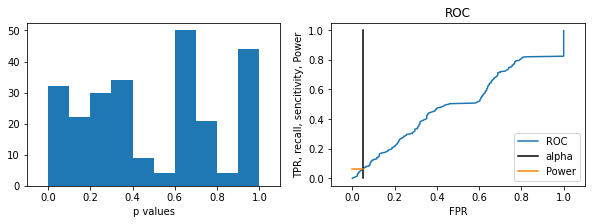

In [14]:
N = 250
alpha = 0.05

# pvals = evaluate_pvals(A, A, N, "mean")
pvals, method = evaluate_pvals(A, A, N, "median")

FP = np.mean(np.array(pvals) < alpha)
print(f"method: {method}, false positives: {FP}")

plot_the_couple(pvals, N, FP, alpha)

  0%|          | 0/250 [00:00<?, ?it/s]

method: median, false positives: 0.044


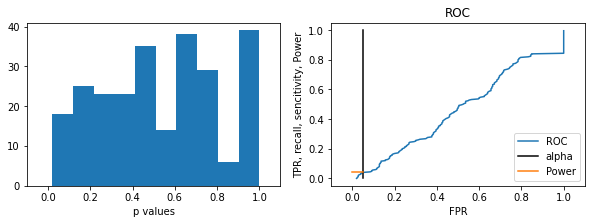

In [15]:
N = 250
alpha = 0.05

# pvals = evaluate_pvals(B, B, N, "mean")
pvals, method = evaluate_pvals(B, B, N, "median")

FP = np.mean(np.array(pvals) < alpha)
print(f"method: {method}, false positives: {FP}")

plot_the_couple(pvals, N, FP, alpha)

### Power for A/B test

  0%|          | 0/250 [00:00<?, ?it/s]

method: median, power: 48%


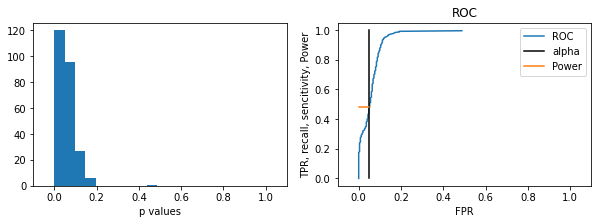

In [16]:
N = 250
alpha = 0.05

# pvals, method = evaluate_pvals(A, B, N, "mean")
pvals, method = evaluate_pvals(A, B, N, "median")

FP = np.mean(np.array(pvals) < alpha)
print(f"method: {method}, power: {round(FP * 100)}%")

plot_the_couple(pvals, N, FP, alpha)

  0%|          | 0/250 [00:00<?, ?it/s]

method: mean, power: 80%


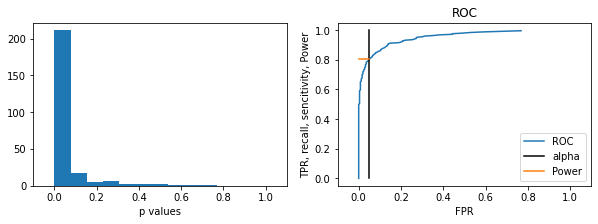

In [17]:
N = 250
alpha = 0.05

pvals, method = evaluate_pvals(A, B, N, "mean")
# pvals, method = evaluate_pvals(A, B, N, "median")

FP = np.mean(np.array(pvals) < alpha)
print(f"method: {method}, power: {round(FP * 100)}%")

plot_the_couple(pvals, N, FP, alpha)